<a href="https://www.kaggle.com/code/averma111/pytorch-icr?scriptVersionId=129358596" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import torch.nn.functional as F
import warnings
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import MulticlassF1Score
from torchmetrics.classification import MulticlassAccuracy
warnings.filterwarnings('ignore')
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
plt.style.use('ggplot')
sns.set_style("darkgrid")
pd.set_option('mode.chained_assignment',None)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def get_datasets(path):
    df = pd.read_csv(path)
    return df

train_path='/kaggle/input/icr-identify-age-related-conditions/train.csv'
test_path ='/kaggle/input/icr-identify-age-related-conditions/test.csv'
greeks_path = '/kaggle/input/icr-identify-age-related-conditions/greeks.csv'
submission_path ='/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv'

In [3]:
get_datasets(train_path).head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


In [4]:
def summary(text, df):
    print(f'{text} shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summ['null'] = df.isnull().sum()
    summ['unique'] = df.nunique()
    summ['min'] = df.min()
    summ['median'] = df.median()
    summ['max'] = df.max()
    summ['mean'] = df.mean()
    summ['std'] = df.std()
    summ['duplicate'] = df.duplicated().sum()
    return summ

## Summary of train dataset 

* There are no duplicates.
* BQ,CB,CC,DU,EL,FC,FL,FS and GL are nulls
* All the features are in float

In [5]:
summary('train',get_datasets(train_path))

train shape: (617, 58)


,dtypes,null,unique,min,median,max,mean,std,duplicate
Id,object,0,617,000ff2bfdfe9,NaN,ffcca4ded3bb,NaN,NaN,0
AB,float64,0,217,0.081187,0.354659,6.161666,0.477149,0.468388,0
AF,float64,0,599,192.59328,3120.318960,28688.18766,3502.013221,2300.322717,0
AH,float64,0,227,85.200147,85.200147,1910.123198,118.624513,127.838950,0
AM,float64,0,605,3.177522,20.533110,630.51823,38.968552,69.728226,0
AR,float64,0,130,8.138688,8.138688,178.943634,10.128242,10.518877,0
AX,float64,0,427,0.699861,5.031912,38.27088,5.545576,2.551696,0
AY,float64,0,148,0.025578,0.025578,10.315851,0.060320,0.416817,0
AZ,float64,0,484,3.396778,10.461320,38.971568,10.566447,4.350645,0
BC,float64,0,259,1.2299,1.229900,1463.693448,8.053012,65.166943,0


In [6]:
def replace_null_with_mean(df):
    fields = ['BQ','CB','CC','DU','EL','FC','FL','FS','GL']
    for value in fields:
        df.fillna(df[value].mean(),axis =1,inplace=True)
    return df

train_non_nan=replace_null_with_mean(get_datasets(train_path))


<AxesSubplot: xlabel='Class', ylabel='count'>

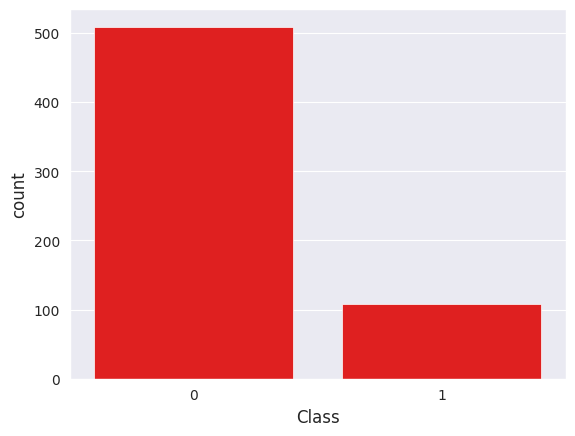

In [7]:
sns.countplot(train_non_nan,x='Class',color='r')


In [8]:
def to_numerical_ecoding(df,column):
    encoding = {
        'A':0,
        'B':1
    }
    for values in df[column]:
        if values =='A':
            df[column] = encoding['A']
        else:
            df[column] = encoding['B']
    return df

train = to_numerical_ecoding(train_non_nan,'EJ')
train = train.set_index('Id')

In [9]:
def drop_column(df,column):
    df.drop(columns=column,axis=1,inplace=True)
    return df

In [10]:
y = train['Class']
X = drop_column(train,['Class'])
y = y.astype(float)
X = X.astype(float)

## Distribution plot for data in training set 
* Negative and Positve Skewness 

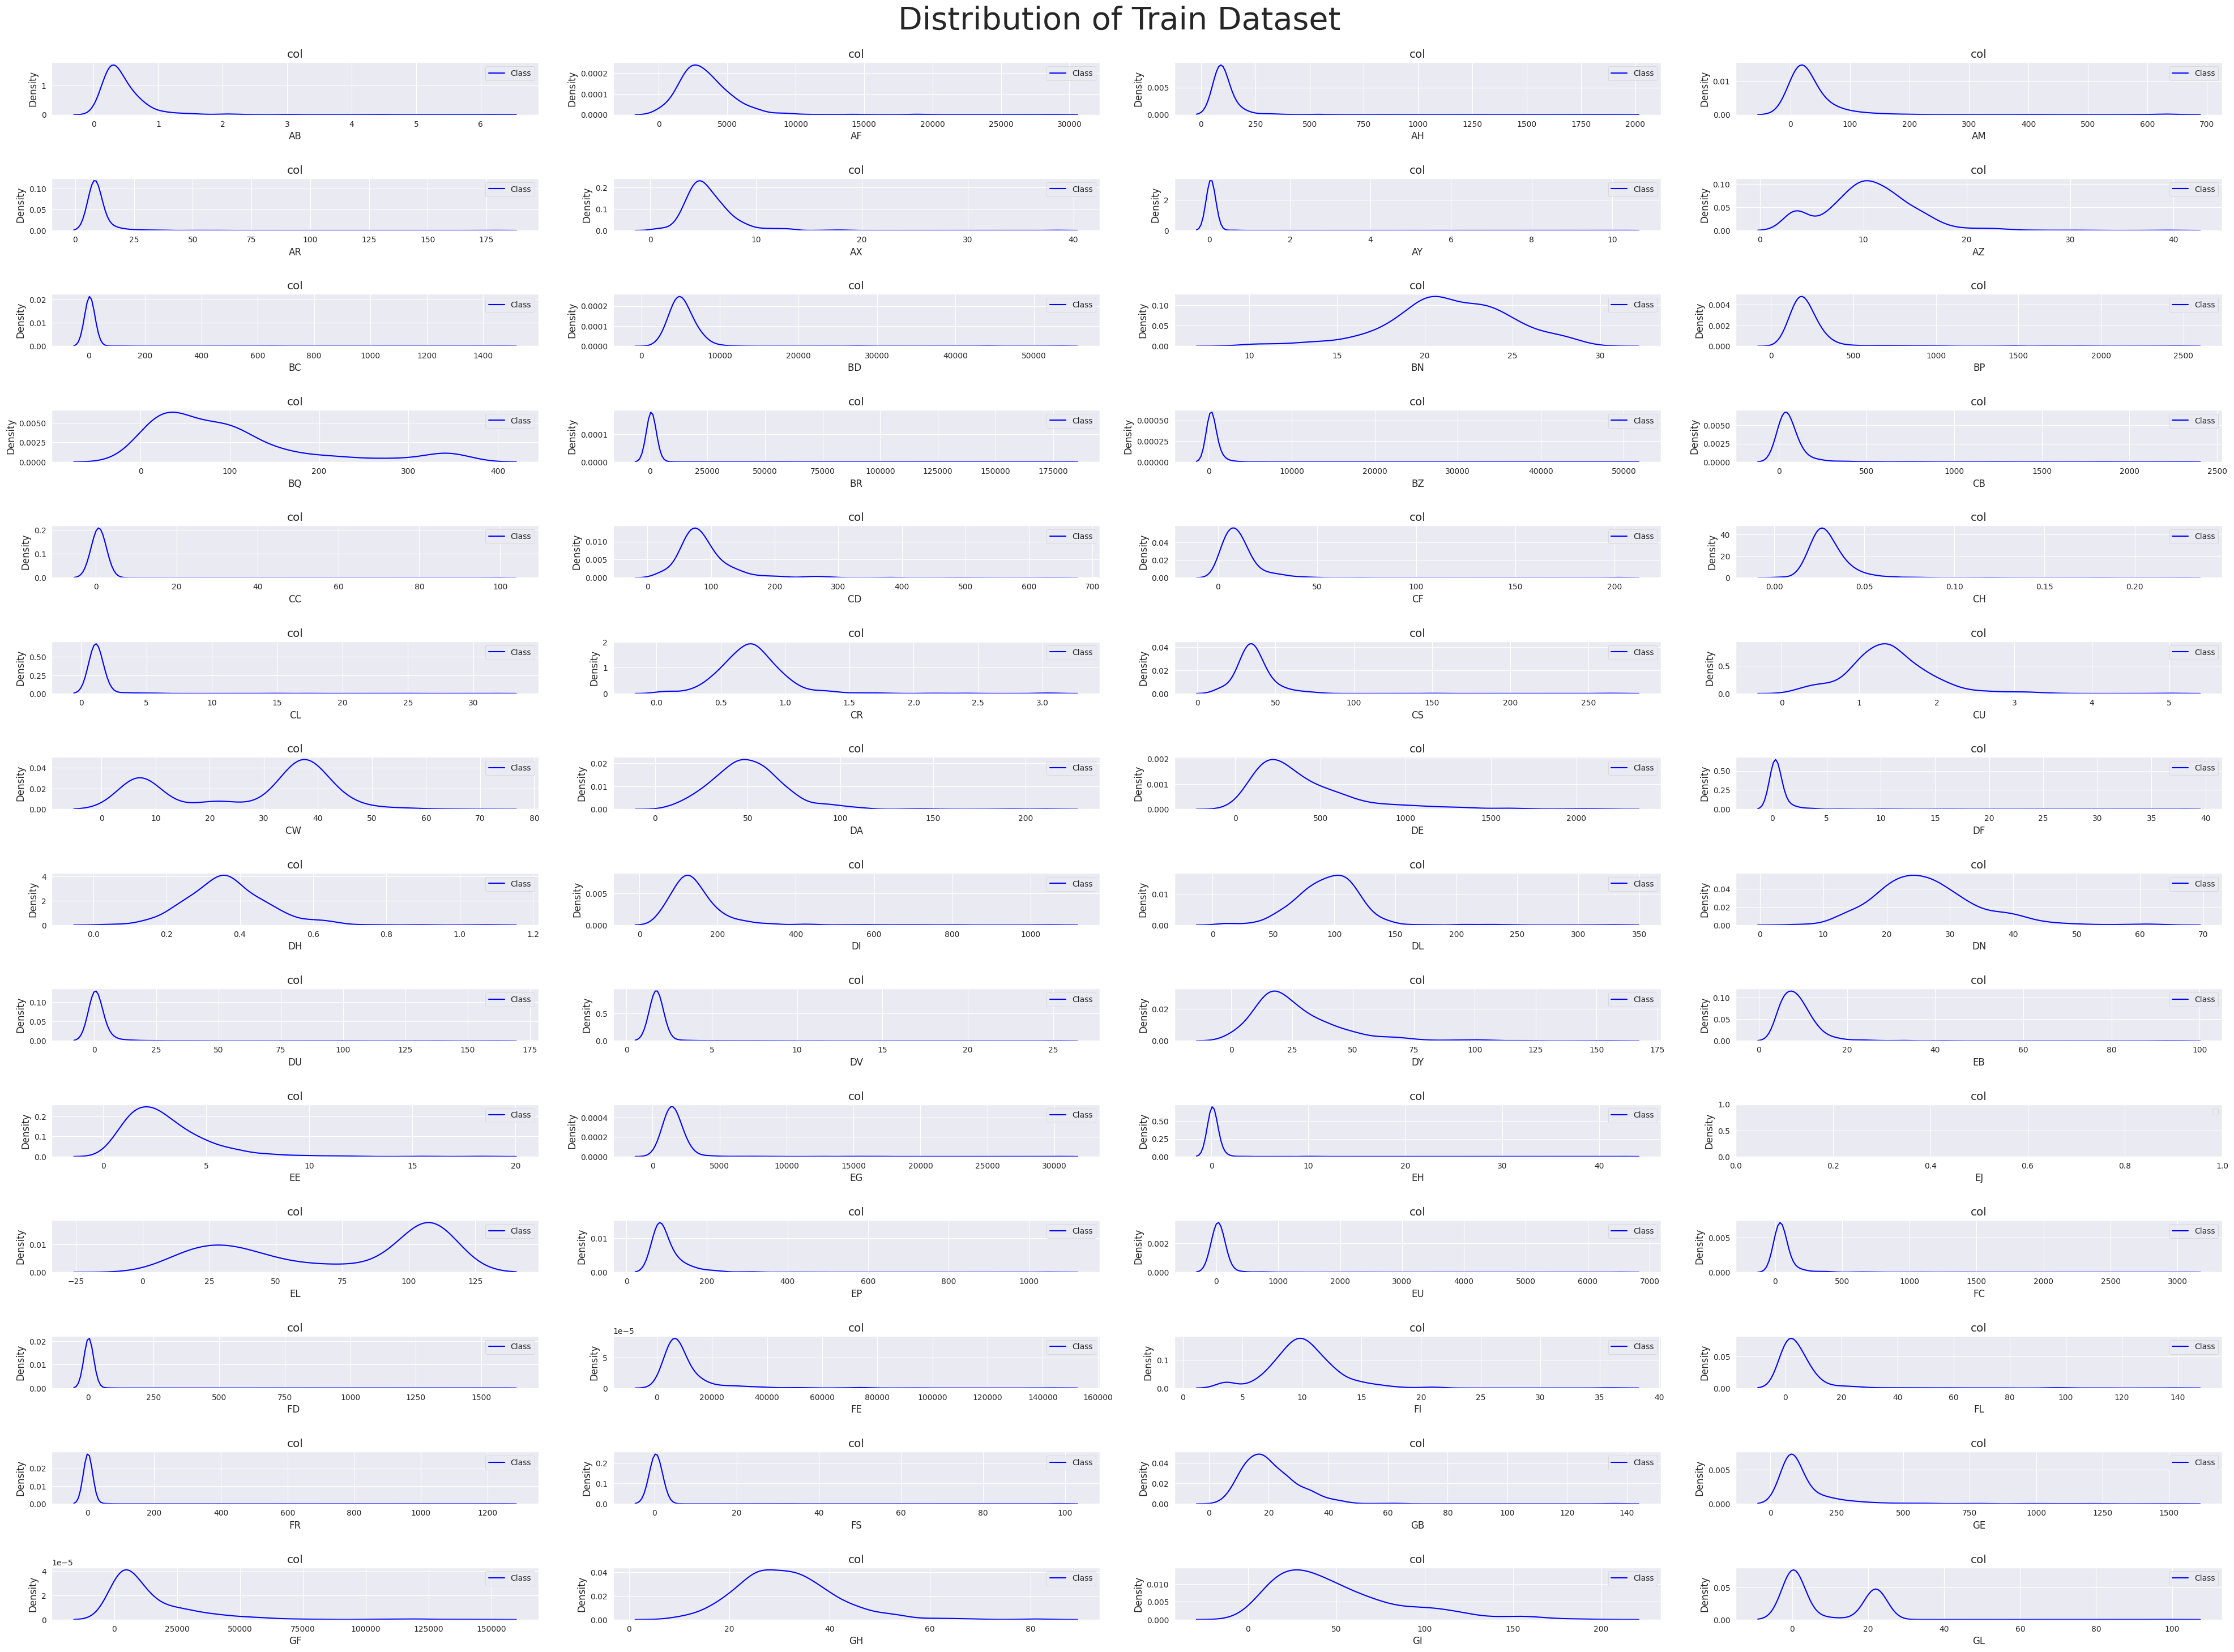

In [11]:
def plot_kde_train(features):
    fig,ax = plt.subplots(int(np.ceil(len(features.columns)/4)),4, figsize = (40,30))
    for i,col in enumerate(features.columns):
        ax = np.ravel(ax)
        sns.kdeplot(x= features[col] , label = 'Class', ax = ax[i],color='b')
        ax[i].legend()
        ax[i].set_title(f"col")

    plt.suptitle("Distribution of Train Dataset",fontsize = 40)
    plt.tight_layout(pad =3)
    plt.show()
    
plot_kde_train(X)

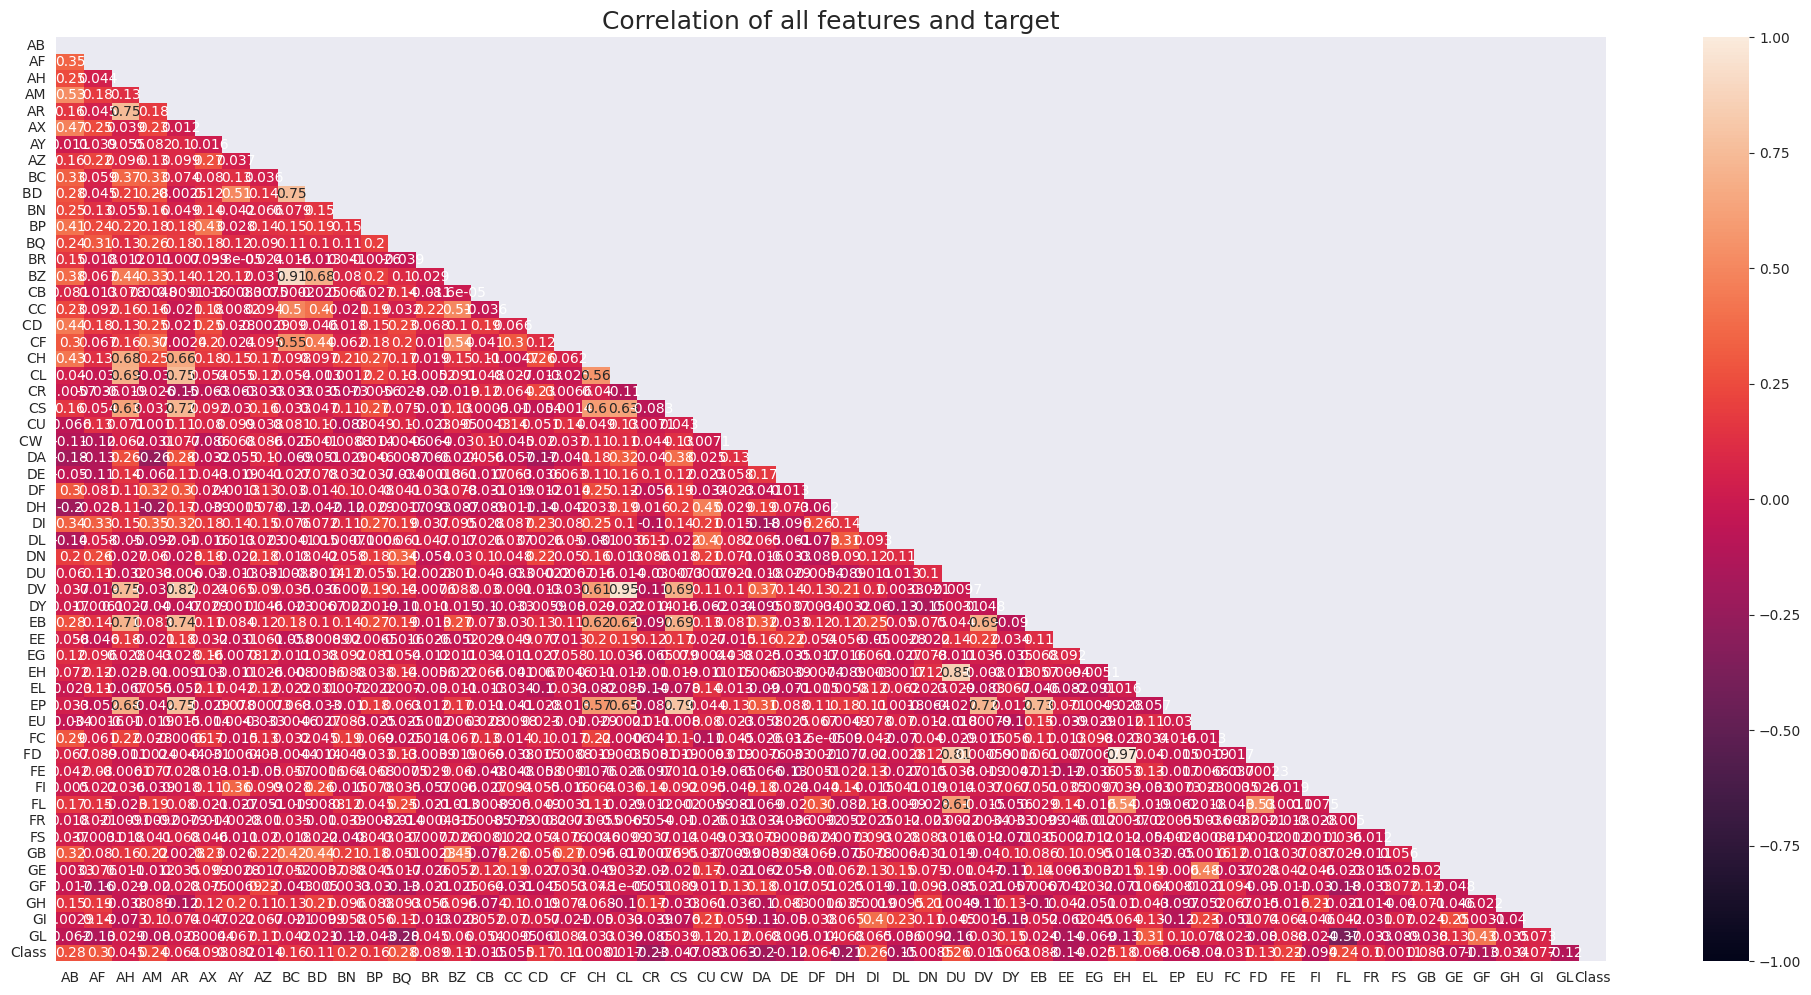

In [12]:
def  plot_correlation_dataset(df):
    plt.figure(figsize = (25,12))
    corr = df.corr()
    upper_triangle = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr,vmin = -1, vmax = 1, cmap = "rocket", annot = True, mask = upper_triangle)
    plt.title("Correlation of all features and target", fontsize= 18)
    plt.show()
    
plot_correlation_dataset(get_datasets(train_path))

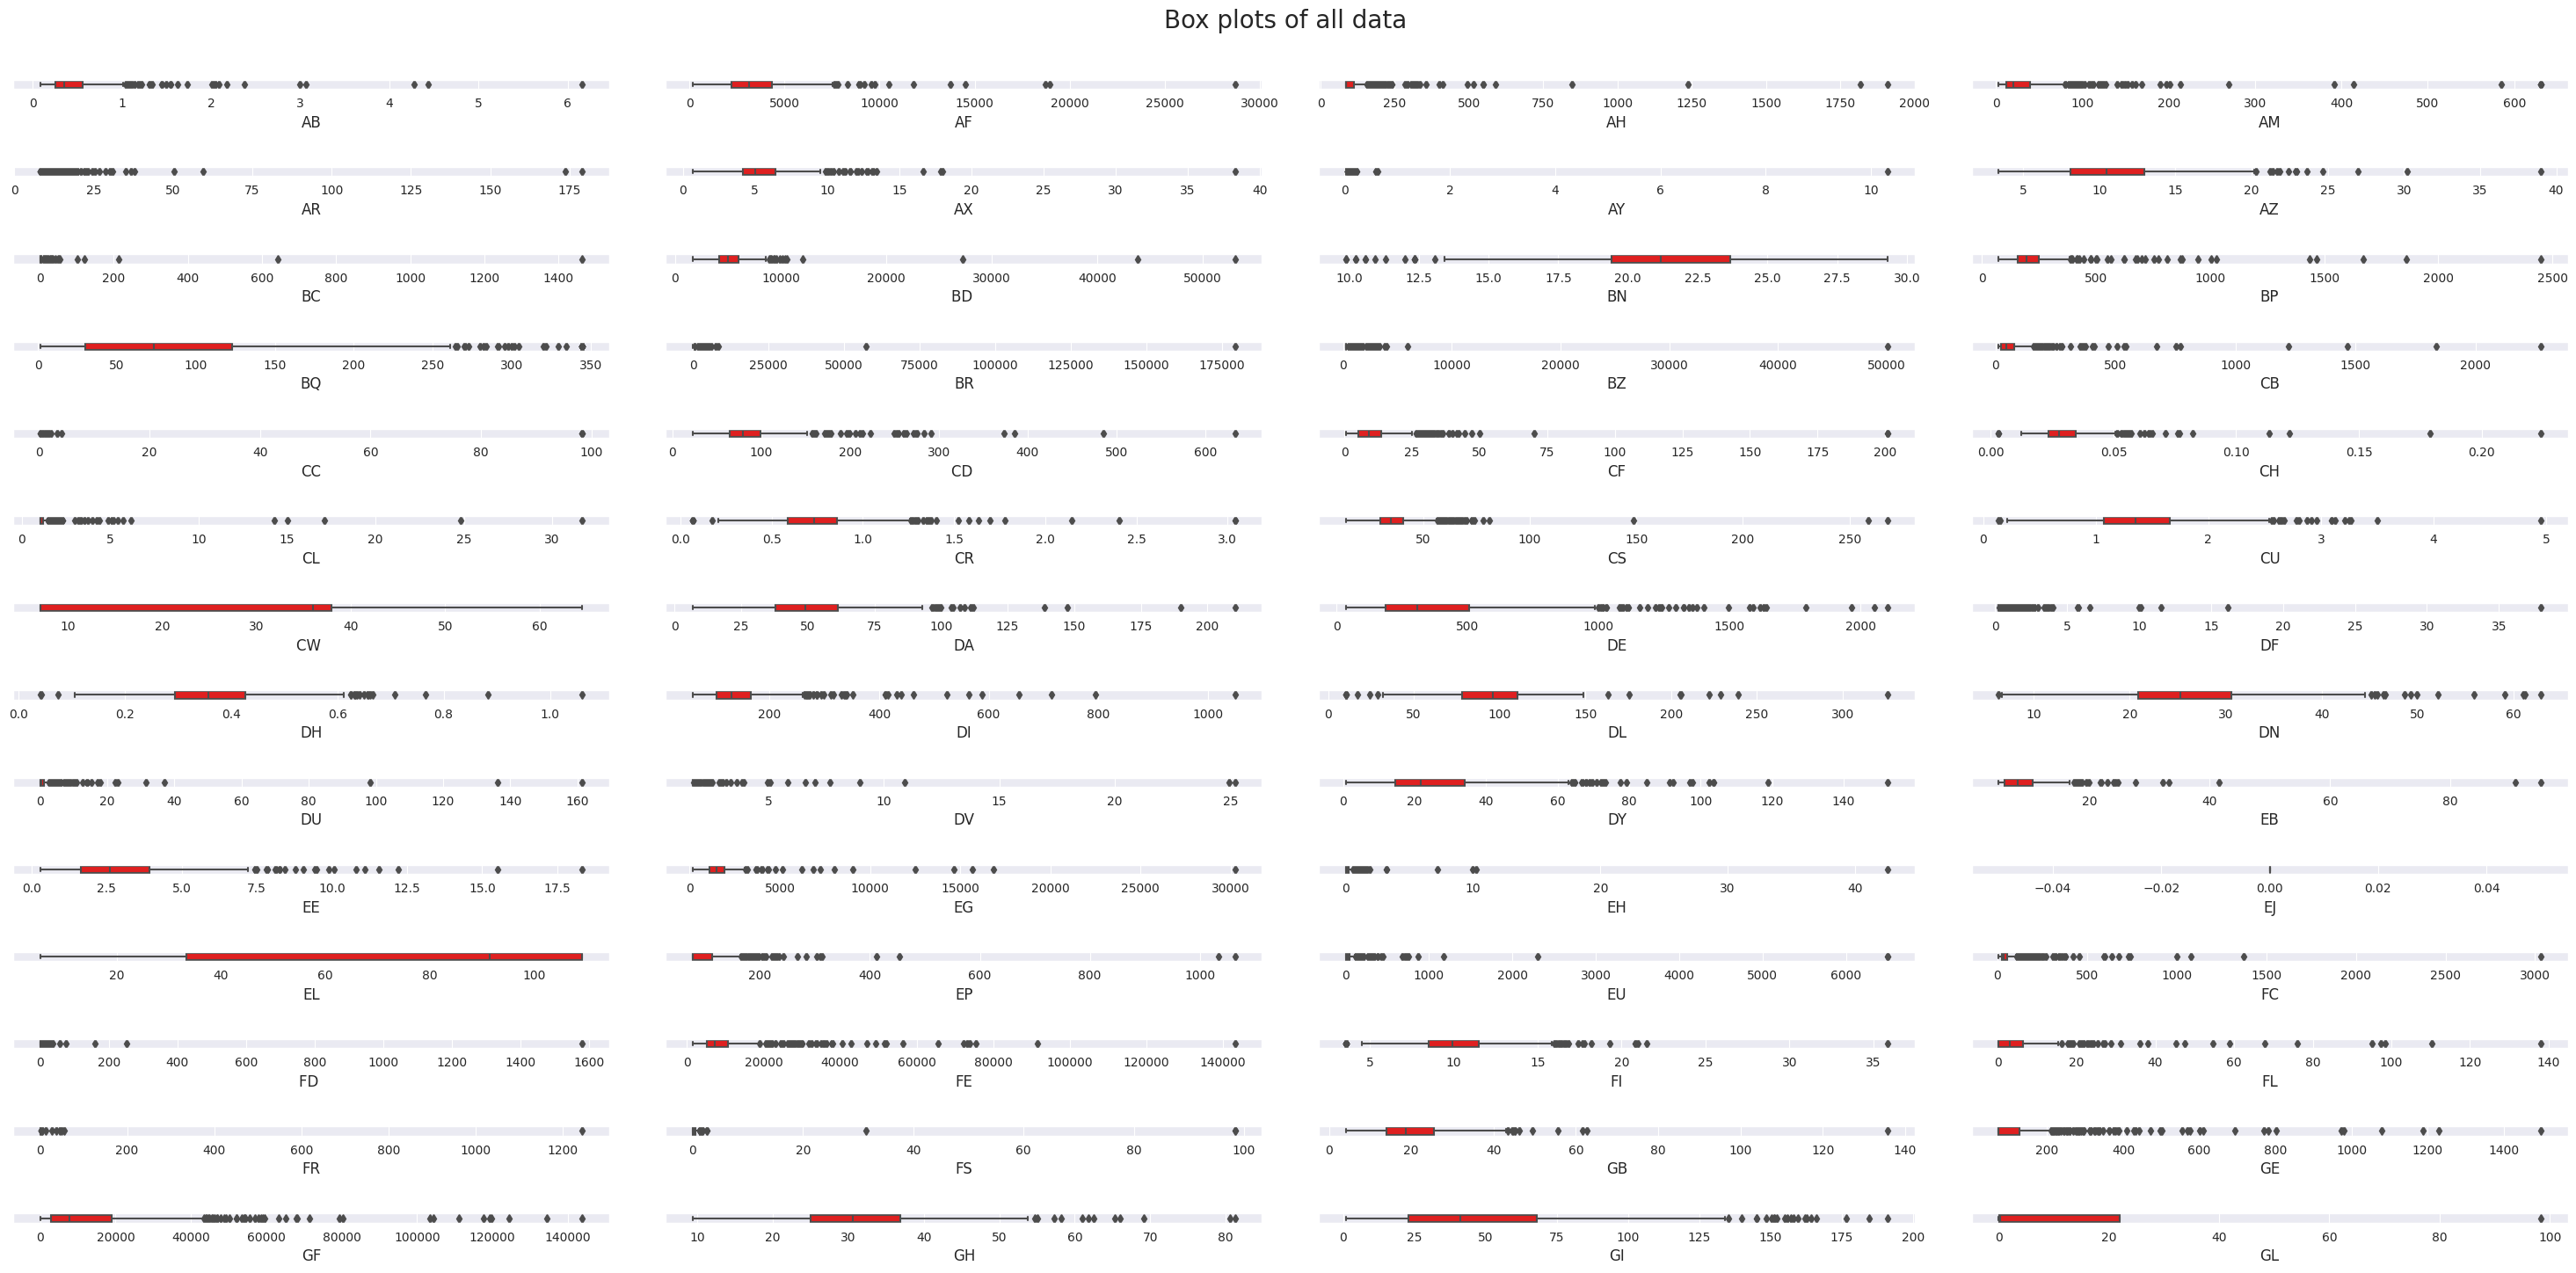

In [13]:
def show_outlier(features):
    fig,ax = plt.subplots(int(np.ceil(len(X.columns)/4)),4,figsize = (30,15))
    ax = np.ravel(ax)
    for i,col in enumerate(X.columns):
        sns.boxplot(ax = ax[i], x = X[col], color= "red")
    fig.suptitle("Box plots of all data ",fontsize = 20)
    plt.tight_layout(pad=3)
    plt.show()

show_outlier(X)

In [14]:
def preprocessing(features,label=None):
    scaler = StandardScaler()
    num_cols = list(features.select_dtypes(include=['float']))
    features = scaler.fit_transform(features[num_cols].values)
    if label is not None:
        return train_test_split(features,label.to_numpy(),test_size=0.2,random_state=42)
    elif label is None:
        return features

X_train,X_val,y_train,y_val = preprocessing(X,y)
print(X_train.shape,X_val.shape,y_train.shape,y_val.shape)



(493, 56) (124, 56) (493,) (124,)


In [15]:
def convert_to_torch(value):
    return torch.tensor(data=value,dtype=torch.float32,requires_grad=True)

In [16]:
class Data(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
            return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

X_data = convert_to_torch(X_train)
y_data = convert_to_torch(y_train).type(torch.LongTensor)
X_val = convert_to_torch(X_val)
y_val = convert_to_torch(y_val).type(torch.LongTensor)
train_data = Data(X_data,y_data)
val_data = Data(X_val,y_val)

In [17]:
class ICRClassificationBase(torch.nn.Module):
    
    def training_step(self,batch):
        fetures,labels = batch
        out = self(fetures)
        loss = F.cross_entropy(out,labels)
        return loss
    
    def validation_step(self, batch):
        fetures, labels = batch 
        out = self(fetures)                    
        loss = F.cross_entropy(out, labels)   
        acc = accuracy(out, labels)          
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        if epoch%10 ==0:
            print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
                epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [18]:
class ICRNNet(ICRClassificationBase):
    def __init__(self,input_features,num_classes):
        super().__init__()
        self.network = torch.nn.Sequential(
        torch.nn.Linear(input_features,24),
        torch.nn.ReLU(),
        torch.nn.Dropout(p=0.5),    
        torch.nn.Linear(24, 12),
        torch.nn.ReLU(),
        torch.nn.Dropout(p=0.5),    
        torch.nn.Linear(12, num_classes)   
        )      
    
    def forward(self,inputs):
        return self.network(inputs)
    

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
input_features = X_train.shape[1]
num_classes = 2
model = ICRNNet(input_features,num_classes)
model.to(device)

ICRNNet(
  (network): Sequential(
    (0): Linear(in_features=56, out_features=24, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=24, out_features=12, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=12, out_features=2, bias=True)
  )
)

In [20]:
def get_dataloaders(dataset_type,batch,shuffle):
    if shuffle:
         return DataLoader(dataset=dataset_type, batch_size=batch, shuffle=True)
    else:
        return DataLoader(dataset=dataset_type, batch_size=batch,shuffle=False)

In [21]:

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
  
@torch.no_grad()
def evaluate(model, test_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in test_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, test_loader, opt_func):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    
    for epoch in tqdm(range(epochs)):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)    
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        result = evaluate(model, test_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    print('Training Completed!!')
    
    return history

In [22]:
num_epochs = 100
opt_func =  torch.optim.Adam
lr = 0.001
batch_size = 8



In [23]:
train_dataloader = get_dataloaders(train_data,batch_size,True)
val_dataloader = get_dataloaders(val_data,batch_size,False)


In [24]:
history = fit(num_epochs, lr, model, train_dataloader, val_dataloader, opt_func)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.6021, val_loss: 0.5274, val_acc: 0.8125
Epoch [10], train_loss: 0.2313, val_loss: 0.3307, val_acc: 0.8438
Epoch [20], train_loss: 0.1415, val_loss: 0.3442, val_acc: 0.8750
Epoch [30], train_loss: 0.0955, val_loss: 0.3978, val_acc: 0.8906
Epoch [40], train_loss: 0.0954, val_loss: 0.4564, val_acc: 0.8828
Epoch [50], train_loss: 0.0810, val_loss: 0.4499, val_acc: 0.9141
Epoch [60], train_loss: 0.0862, val_loss: 0.5542, val_acc: 0.9062
Epoch [70], train_loss: 0.0457, val_loss: 0.6488, val_acc: 0.8906
Epoch [80], train_loss: 0.0575, val_loss: 0.6278, val_acc: 0.8906
Epoch [90], train_loss: 0.0459, val_loss: 0.6899, val_acc: 0.8984
Training Completed!!


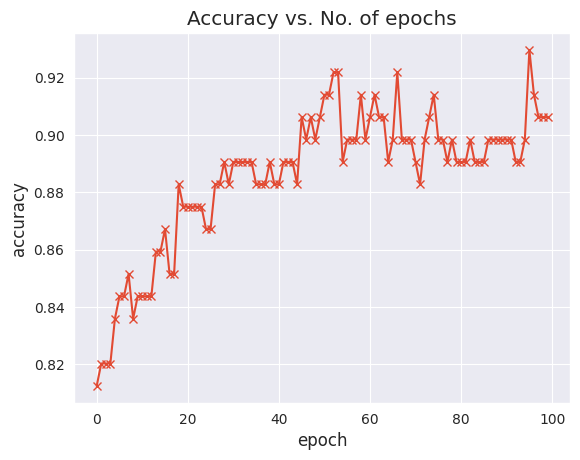

In [25]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    

plot_accuracies(history)



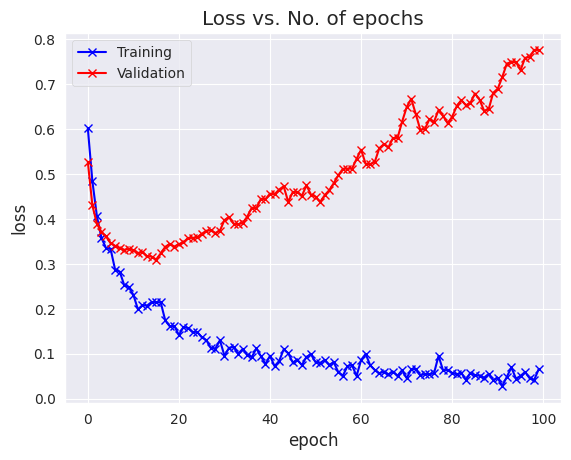

In [26]:
def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [27]:
torch.save(model,'/kaggle/working/ICRClassification.pt')

In [28]:
class Data_Test(Dataset):
    
    def __init__(self, X_test_data):
        self.X_test_data = X_test_data
        
    def __getitem__(self, index):
        return self.X_test_data[index]
        
    def __len__ (self):
        return len(self.X_test_data)

In [29]:
def convert_to_torch(value):
    return torch.tensor(data=value,dtype=torch.float32,requires_grad=True)

In [30]:
submission_df = get_datasets(submission_path).set_index("Id")

In [34]:
def make_predictions(model):
    test_df = get_datasets(test_path)
    test = to_numerical_ecoding(test_df,'EJ')
    test['EJ'] = test['EJ'].astype(float)
    testing_data = Data_Test(convert_to_torch(preprocessing(test)))
    test_dataloader = DataLoader(testing_data, batch_size=1, shuffle=False)
    
    model.eval()
    ids_ = np.empty(shape=(len(test),), dtype=object)
    class_0_ = np.empty(shape=(len(test),))
    class_1_ = np.empty(shape=(len(test),))
    
    with torch.no_grad():
        for i,features in tqdm(enumerate(test_dataloader)):
            output = model(features)
            probs=F.softmax(output, dim=1).squeeze().detach().cpu().numpy()   
            class_0_[i] = probs[0]
            class_1_[i] = probs[0]
            ids_[i] = test.index[i]

    submission = pd.DataFrame(data={"Id" : ids_, "class_0" : class_0_, "class_1" : class_1_})
    print("Prediction Completed")
    return submission

In [35]:
    model_test = torch.load('/kaggle/working/ICRClassification.pt')
    model_test.to(device)


ICRNNet(
  (network): Sequential(
    (0): Linear(in_features=56, out_features=24, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=24, out_features=12, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=12, out_features=2, bias=True)
  )
)

In [36]:
submission_df =  make_predictions(model_test)

0it [00:00, ?it/s]

Prediction Completed


In [37]:
submission_df.to_csv("/kaggle/working/submission.csv", index=False)
print("Submission Completed")

Submission Completed
